In [64]:
# -*- coding: utf-8 -*-
"""
Transformer Stock Price Prediction with Walk-Forward Validation

This notebook implements a Transformer model for stock price prediction
using a Walk-Forward Validation strategy to provide a more robust evaluation
and account for evolving market dynamics, including recent volatility.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
import math
from datetime import timedelta, datetime
import os # Import os module

Attempting to load processed data for Transformer prediction from: VST_merged_dataset_VST.csv
Data loaded successfully. Shape: (1087, 40)
Columns available: ['calendarYear', 'period', 'revenue', 'grossProfit', 'netIncome', 'operatingIncome', 'eps', 'epsdiluted', 'researchAndDevelopmentExpenses', 'operatingExpenses', 'grossProfitRatio', 'operatingIncomeRatio', 'netIncomeRatio', 'weightedAverageShsOutDil', 'Close', 'High', 'Low', 'Open', 'Volume', 'days_since_financial_update', 'price_change_pct', 'price_change', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'RSI', 'returns', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'PE_ratio', 'volume_change', 'volume_ma_5', 'momentum_5d', 'momentum_10d', 'momentum_20d', 'market_cap', 'price_to_sales']
Date range: 2020-12-31 00:00:00 to 2025-04-30 00:00:00

Processed data loaded successfully. Running Transformer prediction with Walk-Forward Validation.

==== Starting Transformer Prediction with Walk-Forward Validation ====
Using 27 features: 

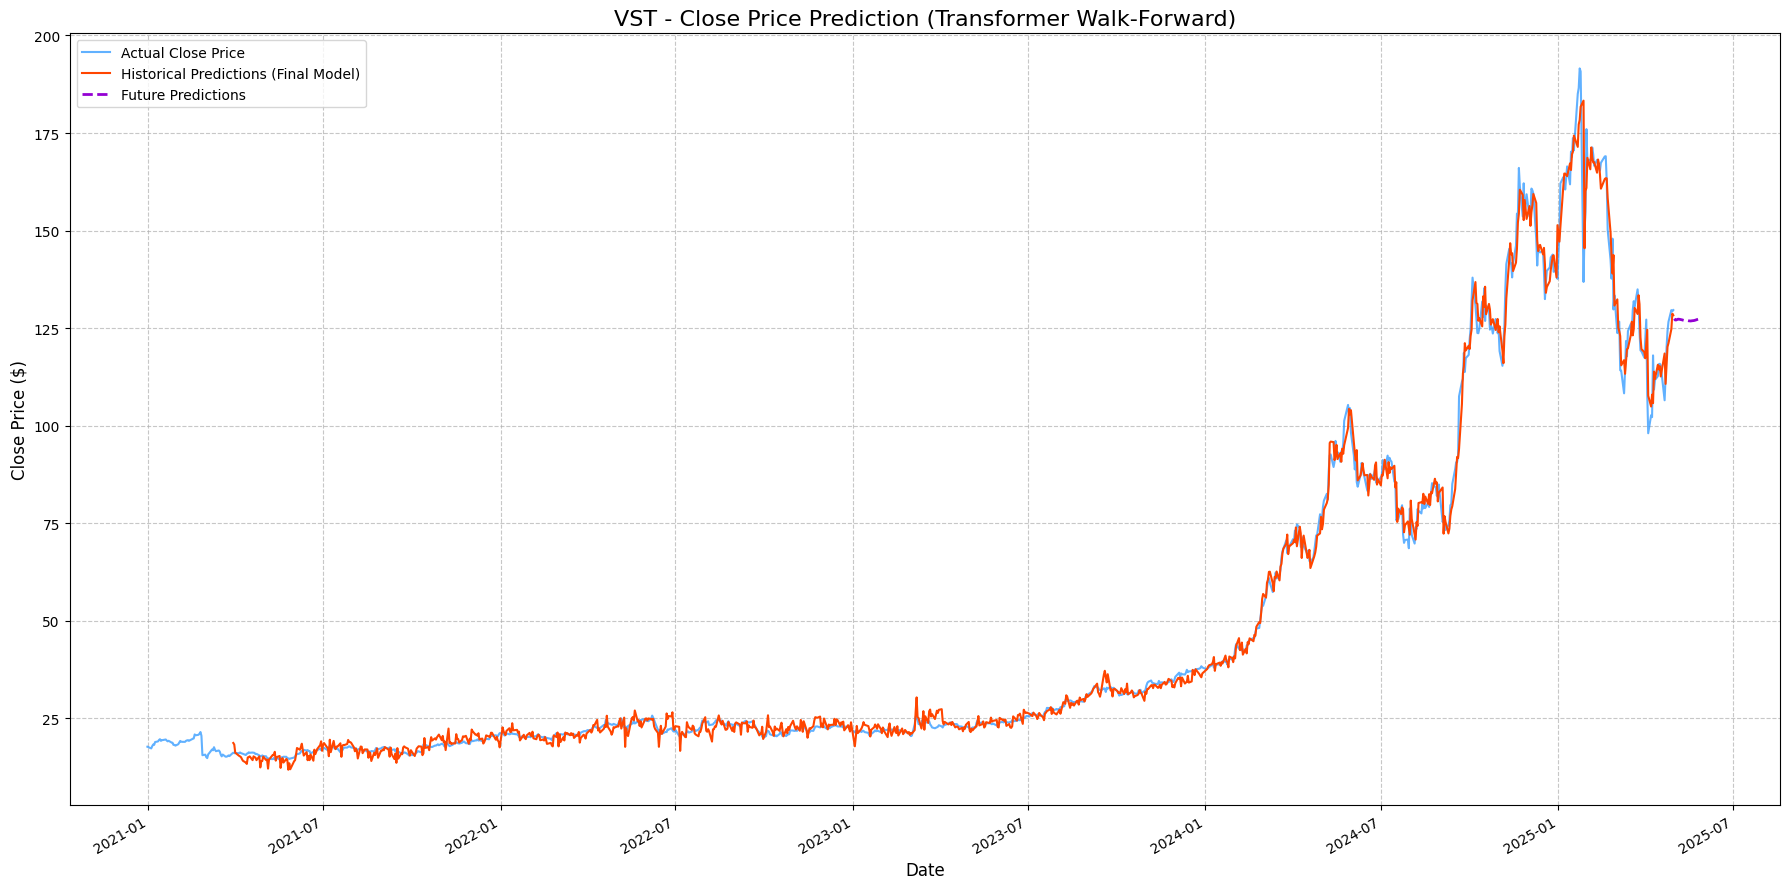

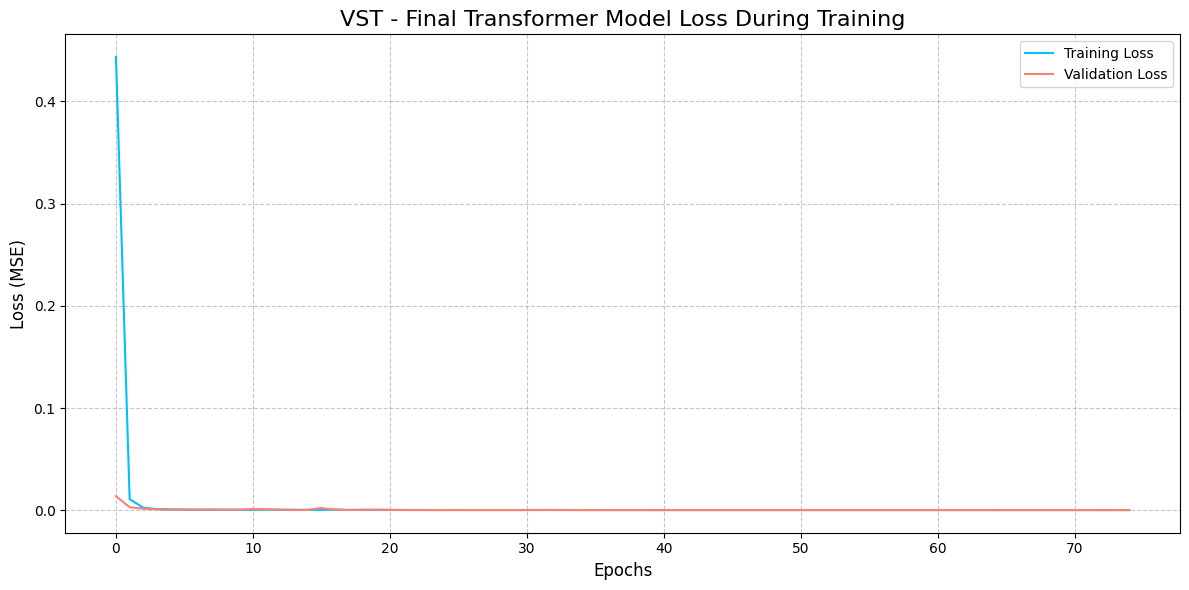

Final model saved as 'VST_transformer_walk_forward_final_model.h5'
Combined historical and future predictions saved to 'VST_transformer_historical_and_future_wf.csv'

==== Walk-Forward Validation Summary ====
Average Validation RMSE across folds: 13.8574
Average Validation MAE across folds: 13.4254
Average Validation R² across folds: -11.2564

==== Transformer Future Predictions for the next 30 days (Final Model) ====
            Predicted_Close
2025-05-01       127.405594
2025-05-02       127.091980
2025-05-03       127.099419
2025-05-04       127.212563
2025-05-05       127.304436
...
            Predicted_Close
2025-05-26       127.320137
2025-05-27       127.405159
2025-05-28       127.491829
2025-05-29       127.561760
2025-05-30       127.608803


In [ ]:
# --- Feature Selection ---
# Define the list of features to use for training the model.
# Ensure these columns exist in your processed data DataFrame.
FEATURES_TO_USE = [
    # Core price/volume (5)
    'Volume', 'price_change_pct',

    # Expanded Technical indicators (now 14) - Added more from available columns
    'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MA_200', # Moving Averages
    'RSI',                                     # Relative Strength Index
    'returns',                                 # Daily Returns
    'volatility_5d', 'volatility_10d', 'volatility_20d', # Volatility measures
    'momentum_5d', 'momentum_10d', 'momentum_20d', # Momentum measures
    'volume_change', 'volume_ma_5',             # Volume indicators

    # Key fundamentals (4) - Keep these
    'eps', 'revenue', 'netIncomeRatio', 'PE_ratio',

    # Context (2) - Keep these
    'days_since_financial_update', 'market_cap',
    'price_to_sales' # Added price_to_sales
]

# --- Transformer Components ---

def positional_encoding(length, depth):
    """Calculates positional encoding for a sequence."""
    depth = depth / 2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(layers.Layer):
    """Combines input features with positional encoding."""
    def __init__(self, d_model, max_len=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
        # Positional encoding is pre-calculated up to max_len
        self.pos_encoding = positional_encoding(self.max_len, d_model)

        # Dense layer to project input features to d_model dimension
        self.projection_layer = layers.Dense(d_model)

    def call(self, x):
        # x shape: (batch_size, input_seq_length, num_features)

        # Project input features to d_model dimension
        x = self.projection_layer(x) # Output shape: (batch_size, input_seq_length, d_model)

        # Add positional encoding. Slice pos_encoding to match current sequence length.
        seq_len = tf.shape(x)[1]
        # Ensure positional encoding slice matches sequence length and d_model
        x += self.pos_encoding[tf.newaxis, :seq_len, :]
        return x

class BaseAttention(layers.Layer):
    """Base class for attention layers."""
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = layers.MultiHeadAttention(**kwargs)
        self.layernorm = layers.LayerNormalization()
        self.add = layers.Add()

class GlobalSelfAttention(BaseAttention):
    """Global self-attention layer."""
    def call(self, x):
        # Keras MultiHeadAttention automatically handles masks if attached to the input
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class TransformerEncoderLayer(layers.Layer):
    """A single Transformer encoder layer."""
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model),
            layers.Dropout(dropout_rate)
        ])
        self.add = layers.Add()
        self.layer_norm = layers.LayerNormalization()

    def call(self, x):
        # Self-attention
        x = self.self_attention(x)
        # Feed-forward network
        x = self.add([x, self.ffn(x)])
        x = self.layer_norm(x)
        return x

class TransformerModel(models.Model):
    """The complete Transformer model for time series prediction."""
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_length, num_features, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_seq_length = input_seq_length
        self.num_features = num_features

        # Positional Embedding layer (handles numerical input + positional encoding)
        self.pos_embedding = PositionalEmbedding(d_model=d_model, max_len=input_seq_length)

        # Transformer Encoder layers
        self.encoder_layers = [
            TransformerEncoderLayer(d_model, num_heads, dff, dropout_rate)
            for _ in range(num_layers)
        ]

        # Final Dense layer to predict the single target value
        self.final_layer = layers.Dense(1)

    def call(self, inputs):
        # inputs shape: (batch_size, input_seq_length, num_features)

        # Apply positional embedding (includes projection to d_model)
        x = self.pos_embedding(inputs) # Output shape: (batch_size, input_seq_length, d_model)

        # Pass through encoder layers
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x) # Output shape: (batch_size, input_seq_length, d_model)

        # We want to predict the next step's value based on the *last* output of the sequence
        # Take the output corresponding to the last time step in the input sequence
        last_step_output = x[:, -1, :] # Shape: (batch_size, d_model)

        # Pass the last step's output through the final dense layer to get the prediction
        predictions = self.final_layer(last_step_output) # Shape: (batch_size, 1)

        return predictions

# --- Data Preparation Helper ---

def create_sequences(data_df, seq_length, target_col_name):
    """
    Create sequences from a DataFrame for time series forecasting.

    Args:
        data_df (pd.DataFrame): DataFrame containing the features.
        seq_length (int): The number of time steps in each input sequence.
        target_col_name (str): The name of the target column to predict.

    Returns:
        tuple: (X, y) where X is the input sequences (numpy array)
               and y is the target values (numpy array).
               Returns empty numpy arrays if sequence creation fails.
    """
    X, y = [], []
    data_values = data_df.values # Use .values to work with numpy arrays
    try:
        # Find the index of the target column in the current data_values array
        target_idx_in_values = data_df.columns.get_loc(target_col_name)
    except KeyError:
        print(f"Error: Target column '{target_col_name}' not found in the DataFrame slice used for sequence creation.")
        return np.array([]), np.array([]) # Return empty arrays on error

    for i in range(len(data_values) - seq_length):
        # Input sequence X: sequence_length time steps of all features (from i up to i + seq_length - 1)
        seq_x = data_values[i:(i + seq_length)]
        # Target y: the target value at the end of the sequence + 1 (i.e., at index i + seq_length)
        seq_y = data_values[i + seq_length, target_idx_in_values] # Get target from the next time step
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# --- Model Training Function for a Single Fold ---

def train_transformer_fold(X_train, y_train, X_val, y_val, sequence_length, num_features,
                           num_layers, d_model, num_heads, dff, dropout_rate,
                           epochs, batch_size, patience=15, min_lr=0.00001, lr_factor=0.2, lr_patience=7):
    """
    Build and train the Transformer model for a single fold of data.

    Args:
        X_train (np.ndarray): Training input sequences for this fold.
        y_train (np.ndarray): Training target values for this fold.
        X_val (np.ndarray): Validation input sequences for this fold.
        y_val (np.ndarray): Validation target values for this fold.
        sequence_length (int): Number of time steps in each sequence.
        num_features (int): Number of features per time step.
        num_layers (int): Number of transformer encoder layers.
        d_model (int): Dimensionality of the model's output space.
        num_heads (int): Number of attention heads.
        dff (int): Dimensionality of the feed-forward network.
        dropout_rate (float): Dropout rate.
        epochs (int): Maximum training epochs.
        batch_size (int): Training batch size.
        patience (int): Patience for Early Stopping.
        min_lr (float): Minimum learning rate for ReduceLROnPlateau.
        lr_factor (float): Factor by which the learning rate will be reduced.
        lr_patience (int): Patience for ReduceLROnPlateau.

    Returns:
        tuple: (model, history) - the trained Keras model and training history.
               Returns (None, None) if training cannot proceed.
    """
    if X_train.shape[0] == 0 or X_val.shape[0] == 0:
        print("Warning: Empty train or validation data for this fold. Skipping training.")
        return None, None

    # Build a new instance of the Transformer model for each fold
    model = TransformerModel(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_seq_length=sequence_length,
        num_features=num_features,
        dropout_rate=dropout_rate
    )

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Start with a base LR
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Build the model by passing a dummy input to create the layers
    dummy_input = tf.zeros((1, sequence_length, num_features))
    model(dummy_input)

    # Callbacks for training
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0) # verbose=0 for cleaner output in loop
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=lr_patience, min_lr=min_lr, verbose=0) # verbose=0

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=0) # verbose=0 for cleaner output in loop

    return model, history

# --- Model Evaluation Function for a Single Set ---

def evaluate_set(model, X, y, scalers, target_col='Close'):
    """
    Evaluate the Transformer model performance on a given dataset (train or test/validation).

    Args:
        model (tf.keras.Model): The trained model.
        X (np.ndarray): Input sequences.
        y (np.ndarray): Actual target values (scaled).
        scalers (dict): Dictionary of scalers used for normalization.
        target_col (str): Name of the target column.

    Returns:
        dict: Dictionary of evaluation metrics (RMSE, MAE, R²).
              Returns None if evaluation fails.
    """
    if model is None or X.shape[0] == 0:
        print("Warning: Model is None or input data is empty. Cannot evaluate.")
        return None

    if target_col not in scalers:
        print(f"Error: Scaler for target column '{target_col}' not found during evaluation.")
        return None

    try:
        # Make predictions on the set
        predictions_scaled = model.predict(X, verbose=0) # verbose=0

        # Inverse transform predictions to original scale
        scaler = scalers[target_col]
        predictions = scaler.inverse_transform(predictions_scaled)

        # Inverse transform actual values
        y_orig = scaler.inverse_transform(y.reshape(-1, 1))

        # Ensure shapes match before calculating metrics
        if y_orig.shape[0] != predictions.shape[0]:
            min_len = min(y_orig.shape[0], predictions.shape[0])
            y_orig = y_orig[:min_len]
            predictions = predictions[:min_len]
            print(f"Warning: Actual ({y_orig.shape}) and prediction ({predictions.shape}) shapes mismatch during evaluation. Truncating.")


        # Calculate metrics
        metrics = {
            'rmse': math.sqrt(mean_squared_error(y_orig, predictions)),
            'mae': mean_absolute_error(y_orig, predictions),
            'r2': r2_score(y_orig, predictions)
        }

        return metrics

    except Exception as e:
        print(f"Error during evaluation: {e}")
        return None


# --- Future Prediction Function ---
# This function remains largely the same, but it will be called with the final model
# trained on the full dataset.

def predict_future_transformer(model, df_original, scalers, feature_columns, target_col='Close', sequence_length=60, days_to_predict=365):
    """
    Predict future values using the trained Transformer model.
    df_original: The original dataframe (before any processing specific to train/test splits).
    scalers: Dictionary of scalers for each feature from the final training run.
    feature_columns: List of feature column names used in the model.
    """
    print(f"\n==== Predicting {days_to_predict} Days into the Future for {GLOBAL_STOCK_TICKER} ====")
    if model is None:
        print("Error: Model is not trained. Cannot predict future.")
        return None, None

    # We need the last 'sequence_length' days of data to start the prediction process.
    # This data should be processed (NaNs dropped for the relevant features) and scaled.

    # 1. Get the relevant columns from the original dataframe and drop NaNs
    data_for_future_base = df_original[feature_columns].dropna()

    if len(data_for_future_base) < sequence_length:
        print(f"Error: Not enough historical data ({len(data_for_future_base)} rows after NaN drop) to form an initial sequence of length {sequence_length} for future prediction.")
        return None, None

    # 2. Get the last 'sequence_length' records from this cleaned data (unscaled)
    last_sequence_actual_df = data_for_future_base.tail(sequence_length).copy()

    # 3. Scale this initial sequence using the saved scalers
    current_sequence_scaled_list = []
    for col_name in feature_columns: # Iterate in the order of feature_columns
        if col_name in scalers:
            # Reshape because scaler expects 2D array
            scaled_col_data = scalers[col_name].transform(last_sequence_actual_df[col_name].values.reshape(-1, 1)).flatten()
            current_sequence_scaled_list.append(scaled_col_data)
        else:
            # This should ideally not happen if all features used for training have scalers
            print(f"Warning: Scaler for column '{col_name}' not found during future prediction preparation. Using unscaled values (this may lead to errors).")
            current_sequence_scaled_list.append(last_sequence_actual_df[col_name].values.flatten())

    # Transpose to get shape (sequence_length, num_features)
    current_sequence_scaled = np.array(current_sequence_scaled_list).T

    # Get target scaler for inverse transforming predictions
    if target_col not in scalers:
        print(f"Error: Scaler for target column '{target_col}' not found for inverse transformation.")
        return None, None
    target_scaler = scalers[target_col]

    # Find the index of the target column in the feature_columns list
    try:
        target_idx_in_features = feature_columns.index(target_col)
    except ValueError:
        print(f"Error: Target column '{target_col}' not found in feature_columns list: {feature_columns}")
        return None, None

    future_predictions_unscaled = [] # Store unscaled (actual price) predictions

    # Maintain a rolling window of the last 'sequence_length' feature vectors (scaled)
    # This is what the Transformer will use as input for the next prediction.
    rolling_input_sequence_scaled = current_sequence_scaled.copy()

    # Generate future dates
    # Get the last date from the cleaned data used for the final training
    last_date_in_data = data_for_future_base.index[-1]
    future_dates = [last_date_in_data + timedelta(days=i + 1) for i in range(days_to_predict)]

    # Iteratively predict future values
    for i in range(days_to_predict):
        # Reshape rolling_input_sequence_scaled for Transformer model
        # Shape: (1 sample, sequence_length time steps, num_features features)
        X_pred = rolling_input_sequence_scaled.reshape(1, sequence_length, len(feature_columns))

        # Predict the next day's target value (scaled)
        next_day_target_scaled = model.predict(X_pred, verbose=0) # Verbose=0 to reduce console output

        # Inverse transform the predicted target value to its original scale
        next_day_target_unscaled = target_scaler.inverse_transform(next_day_target_scaled)[0, 0]
        future_predictions_unscaled.append(next_day_target_unscaled)

        # --- Prepare the input features for the *next* prediction step ---\n",
        # This requires creating a new feature vector for the predicted day.\n",
        # The new feature vector must have all features the model expects, scaled.\n",
        new_row_scaled_values = np.zeros(len(feature_columns))

        for j, col_name in enumerate(feature_columns):
            if col_name == target_col:
                # For the target column, use the scaled prediction we just made
                new_row_scaled_values[j] = next_day_target_scaled[0, 0]
            # --- Handling other features for the future step ---\n",
            # This is a critical area. For simplicity, we'll carry forward the last known scaled value\n",
            # for non-target features. For better accuracy, you might need:\n",
            # 1. Separate models to predict these features.\n",
            # 2. Logic to recalculate technical indicators based on the new predicted 'Close' price.\n",
            # This implementation uses the carry-forward simplification.\n",
            else:
                 # Carry forward the last known scaled value for other features
                 new_row_scaled_values[j] = rolling_input_sequence_scaled[-1, j]
                 # Removed the warning print inside the loop to avoid excessive output


        # Update the rolling_input_sequence_scaled: remove the oldest row and append the new_row_scaled_values
        rolling_input_sequence_scaled = np.vstack([rolling_input_sequence_scaled[1:], new_row_scaled_values])

    # Convert future predictions list to numpy array
    future_predictions_unscaled = np.array(future_predictions_unscaled).reshape(-1, 1)

    # Create a dataframe with future predictions and dates
    future_df = pd.DataFrame({
        f'Predicted_{target_col}': future_predictions_unscaled.flatten()
    }, index=pd.to_datetime(future_dates)) # Ensure future_dates are datetime objects for index
    future_df.index.name = 'Date'

    # Save future predictions to CSV
    output_filename = f'{GLOBAL_STOCK_TICKER}_transformer_future_predictions.csv'
    try:
        future_df.to_csv(output_filename)
        print(f"Future predictions saved to '{output_filename}'")
    except Exception as e:
        print(f"Error saving future predictions to {output_filename}: {e}")

    return future_predictions_unscaled, future_dates


# --- Visualization Function ---
# Modified to show actual, final model predictions on historical data, and future predictions.

def visualize_predictions(df_original, historical_predictions, historical_dates,
                          future_predictions=None, future_dates=None,
                          target_col='Close', history=None):
    """
    Visualize model predictions against actual prices, including future predictions.

    Args:
        df_original (pd.DataFrame): The original dataframe with actual historical data.
        historical_predictions (np.ndarray): Predictions from the final model on historical data.
        historical_dates (pd.DatetimeIndex): Dates corresponding to the historical predictions.
        future_predictions (np.ndarray, optional): Predicted future values. Defaults to None.
        future_dates (list, optional): Dates for future predictions. Defaults to None.
        target_col (str): Column that was predicted. Defaults to 'Close'.
        history (tf.keras.callbacks.History, optional): Training history from the final model. Defaults to None.
    """
    print("\n==== Visualizing Predictions ====")

    if not isinstance(df_original.index, pd.DatetimeIndex):
        print("Error: Original DataFrame index is not a DatetimeIndex. Cannot visualize.")
        return

    plt.figure(figsize=(18, 9)) # Wider plot for better readability

    # Plot actual historical data
    plt.plot(df_original.index, df_original[target_col], color='dodgerblue', label=f'Actual {target_col} Price', alpha=0.7)

    # Plot historical predictions from the final model
    if historical_predictions is not None and historical_dates is not None and len(historical_predictions) > 0:
         plt.plot(historical_dates, historical_predictions.flatten(),
                  color='orangered', label='Historical Predictions (Final Model)', linewidth=1.5)


    # Plot future predictions if available
    if future_predictions is not None and future_dates is not None and len(future_dates) > 0 and len(future_predictions) > 0:
        plt.plot(future_dates, future_predictions.flatten(), color='darkviolet', linestyle='--', linewidth=2,
                 label='Future Predictions')

    plt.title(f'{GLOBAL_STOCK_TICKER} - {target_col} Price Prediction (Transformer Walk-Forward)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(f'{target_col} Price ($)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Format x-axis dates for better readability
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())\
    # Use AutoDateLocator for more flexible tick placement
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    # plt.savefig(f'{GLOBAL_STOCK_TICKER}_transformer_stock_prediction_walk_forward.png') # Uncomment to save plot
    plt.show()

    # Plot loss during training if history is available (from the final model training)
    if history is not None and history.history:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss', color='deepskyblue')
        if 'val_loss' in history.history:
             plt.plot(history.history['val_loss'], label='Validation Loss', color='salmon')
        plt.title(f'{GLOBAL_STOCK_TICKER} - Final Transformer Model Loss During Training', fontsize=16)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Loss (MSE)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        # plt.savefig(f'{GLOBAL_STOCK_TICKER}_transformer_final_training_loss.png') # Uncomment to save plot
        plt.show()


# --- Main Execution Function with Walk-Forward Validation ---

def predict_transformer_walk_forward(df_original, target_col='Close', sequence_length=60,
                                     initial_train_size_ratio=0.7, # Proportion of data for initial train
                                     validation_size_days=90,      # Size of validation window in days
                                     step_size_days=90,            # How many days to step forward
                                     num_transformer_layers=2, d_model=64, num_heads=4, dff=128, dropout_rate=0.1,
                                     epochs=75, batch_size=32, patience=15, predict_days=30):
    """
    Main function to run Transformer prediction using Walk-Forward Validation.

    Args:
        df_original (DataFrame): Original processed dataframe with features
                                 (should have DatetimeIndex).
        target_col (str): Column to predict (default: 'Close').
        sequence_length (int): Number of time steps for sequences (default: 60).
        initial_train_size_ratio (float): Ratio of data for the first training window.
        validation_size_days (int): Size of each validation window in days.
        step_size_days (int): How many days to move the window forward each step.
        num_transformer_layers (int): Number of transformer encoder layers.
        d_model (int): Dimensionality of the model's output space.
        num_heads (int): Number of attention heads.
        dff (int): Dimensionality of the feed-forward network.
        dropout_rate (float): Dropout rate.
        epochs (int): Maximum training epochs per fold.
        batch_size (int): Training batch size per fold.
        patience (int): Patience for Early Stopping per fold.
        predict_days (int): Number of future days to predict with the final model.

    Returns:
        tuple: (final_model, avg_metrics, future_predictions, future_dates)
               Returns None for any element if a critical error occurs.
    """
    print("\n==== Starting Transformer Prediction with Walk-Forward Validation ====")

    if not isinstance(df_original.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Please set the 'date' column as the index.")
        return None, None, None, None

    # --- Initial Data Cleaning and Feature Selection ---
    # This part happens once at the beginning
    feature_columns = [col for col in FEATURES_TO_USE if col in df_original.columns]
    if target_col not in feature_columns:
        if target_col in df_original.columns:
            feature_columns.append(target_col)
        else:
            print(f"Error: Target column '{target_col}' not found in the DataFrame.")
            return None, None, None, None
    missing_features = [col for col in FEATURES_TO_USE if col not in df_original.columns]
    if missing_features:
        print(f"Warning: The following specified features are missing from the DataFrame: {missing_features}")

    if not feature_columns:
        print("Error: No valid features selected or found in the DataFrame. Exiting prediction.")
        return None, None, None, None

    print(f"Using {len(feature_columns)} features: {feature_columns[:10]}{'...' if len(feature_columns) > 10 else ''}")

    # Create a new dataframe with selected features, dropping NaN rows
    # Drop NaNs only based on the selected feature columns
    cleaned_data = df_original[feature_columns].dropna()

    if len(cleaned_data) < sequence_length + validation_size_days + 1: # Need enough data for initial train + first validation window
        print(f"Error: Not enough data ({len(cleaned_data)} rows) after dropping NaNs to perform walk-forward validation with sequence length {sequence_length} and validation size {validation_size_days} days.")
        return None, None, None, None

    print(f"Cleaned data shape: {cleaned_data.shape}")
    print(f"Date range after cleaning: {cleaned_data.index.min()} to {cleaned_data.index.max()}")

    # --- Walk-Forward Validation Setup ---
    all_dates = cleaned_data.index
    num_total_days = len(all_dates)

    # Determine initial train size in terms of number of data points
    initial_train_size_points = int(num_total_days * initial_train_size_ratio)

    # Ensure initial train size is at least sequence_length to create sequences
    if initial_train_size_points < sequence_length:
         print(f"Error: Initial training size ({initial_train_size_points} points) is less than sequence length ({sequence_length}). Increase initial_train_size_ratio or sequence_length.")
         return None, None, None, None

    # Determine validation size and step size in terms of number of data points
    # Find the number of data points approximately corresponding to validation_size_days and step_size_days
    # This is an approximation as market days vary
    # A more precise method would find the exact index for a date X days after the start of the window
    # For simplicity here, we'll use average days per point or a fixed number of points
    # Let's use a fixed number of points for validation and step size for simplicity in this implementation
    # You might want to refine this based on dates if exact day counts are critical.

    # Let's use a fixed number of points for validation and step based on the approximate number of trading days in the specified period.
    # This is still an approximation but simpler to implement than date-based indexing within the loop.
    # You might need to adjust these based on your specific data frequency.
    validation_size_points = validation_size_days # Approx points per validation window
    step_size_points = step_size_days           # Approx points to step forward

    # Ensure validation and step sizes are reasonable
    if validation_size_points < sequence_length + 1 or step_size_points < 1:
         print(f"Error: Validation size ({validation_size_points}) must be at least sequence_length + 1 ({sequence_length + 1}) and step size ({step_size_points}) must be at least 1.")
         return None, None, None, None

    # The loop will start training from the initial_train_size_points and validate on the subsequent validation_size_points
    # The validation window slides forward by step_size_points
    # The training window expands to include the data from previous validation windows

    # Starting index for the first validation window
    first_validation_start_index = initial_train_size_points

    # Ensure there's at least one full validation window possible
    if first_validation_start_index + validation_size_points > num_total_days:
        print(f"Error: Not enough data for the first validation window. Initial train size + validation size exceeds total data points.")
        return None, None, None, None


    # Store metrics for each fold
    fold_metrics = []
    fold_count = 0

    # --- Walk-Forward Loop ---
    # The training window ends at `train_end_index` (inclusive)
    # The validation window starts at `val_start_index` (inclusive) and ends at `val_end_index` (exclusive)

    # The loop continues as long as a full validation window can be formed
    current_train_end_index = initial_train_size_points - 1 # End of the initial training set
    current_val_start_index = initial_train_size_points # Start of the first validation set

    while current_val_start_index + validation_size_points <= num_total_days:

        fold_count += 1
        print(f"\n==== Starting Walk-Forward Fold {fold_count} ====")

        # Define the indices for the current fold
        train_start_index = 0 # Expanding window always starts from the beginning
        train_end_index = current_train_end_index # Training data goes up to the start of the current validation window - 1
        val_start_index = current_val_start_index
        val_end_index = current_val_start_index + validation_size_points

        print(f"  Train data indices: {train_start_index} to {train_end_index}")
        print(f"  Validation data indices: {val_start_index} to {val_end_index - 1}") # End index is exclusive in slicing

        # Get data slices for the current fold
        train_data_fold = cleaned_data.iloc[train_start_index : train_end_index + 1].copy()
        val_data_fold = cleaned_data.iloc[val_start_index : val_end_index].copy()

        print(f"  Train data shape for fold {fold_count}: {train_data_fold.shape}")
        print(f"  Validation data shape for fold {fold_count}: {val_data_fold.shape}")

        # Check if slices are large enough to create sequences
        if len(train_data_fold) < sequence_length + 1 or len(val_data_fold) < sequence_length + 1:
             print(f"  Warning: Not enough data in train ({len(train_data_fold)}) or validation ({len(val_data_fold)}) slice for fold {fold_count} to create sequences of length {sequence_length}. Skipping fold.")
             # Advance the window and continue to the next fold
             current_train_end_index = current_val_start_index + validation_size_points - 1
             current_val_start_index = current_val_start_index + validation_size_points
             continue # Skip to the next iteration of the while loop


        # Scale data for the current fold - FIT ONLY ON TRAIN DATA OF THIS FOLD
        scalers_fold = {}
        train_scaled_fold = pd.DataFrame(index=train_data_fold.index)
        val_scaled_fold = pd.DataFrame(index=val_data_fold.index)

        for column in feature_columns:
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit scaler on training data of this fold
            train_scaled_fold[column] = scaler.fit_transform(train_data_fold[column].values.reshape(-1, 1)).flatten()
            # Transform validation data of this fold with the same scaler
            val_scaled_fold[column] = scaler.transform(val_data_fold[column].values.reshape(-1, 1)).flatten()
            # Store scaler for this column (only the last one fitted is needed for future prediction)
            scalers_fold[column] = scaler

        # Create sequences for the current fold
        X_train_fold, y_train_fold = create_sequences(train_scaled_fold, sequence_length, target_col)
        X_val_fold, y_val_fold = create_sequences(val_scaled_fold, sequence_length, target_col)

        print(f"  Training sequences shape for fold {fold_count}: {X_train_fold.shape}")
        print(f"  Validation sequences shape for fold {fold_count}: {X_val_fold.shape}")

        if X_train_fold.shape[0] == 0 or X_val_fold.shape[0] == 0:
             print(f"  Warning: Sequence creation failed for fold {fold_count}. Skipping fold.")
             # Advance the window and continue to the next fold
             current_train_end_index = current_val_start_index + validation_size_points - 1
             current_val_start_index = current_val_start_index + validation_size_points
             continue # Skip to the next iteration of the while loop


        # Train the model for the current fold
        model_fold, history_fold = train_transformer_fold(
            X_train_fold, y_train_fold, X_val_fold, y_val_fold,
            sequence_length, X_train_fold.shape[2], # Use num_features from created sequences
            num_transformer_layers, d_model, num_heads, dff, dropout_rate,
            epochs, batch_size, patience
        )

        if model_fold is not None:
            # Evaluate the model on the validation set of this fold
            metrics_fold = evaluate_set(model_fold, X_val_fold, y_val_fold, scalers_fold, target_col)

            if metrics_fold:
                print(f"  Metrics for Fold {fold_count}:")
                print(f"    Validation RMSE: {metrics_fold['rmse']:.4f}")
                print(f"    Validation MAE: {metrics_fold['mae']:.4f}")
                print(f"    Validation R²: {metrics_fold['r2']:.4f}")
                fold_metrics.append(metrics_fold)

        # Advance the window for the next fold (expanding window)
        # The new training window ends at the end of the current validation window
        current_train_end_index = val_end_index - 1
        # The new validation window starts immediately after the previous one
        current_val_start_index = val_end_index

    print(f"\n==== Walk-Forward Validation Complete ({fold_count} folds) ====")

    # --- Aggregate Walk-Forward Metrics ---
    if fold_metrics:
        avg_metrics = {
            'avg_val_rmse': np.mean([m['rmse'] for m in fold_metrics]),
            'avg_val_mae': np.mean([m['mae'] for m in fold_metrics]),
            'avg_val_r2': np.mean([m['r2'] for m in fold_metrics])
        }
        print("\n==== Average Walk-Forward Validation Metrics ====")
        print(f"Average Validation RMSE: {avg_metrics['avg_val_rmse']:.4f}")
        print(f"Average Validation MAE: {avg_metrics['avg_val_mae']:.4f}")
        # Corrected variable name here
        print(f"Average Validation R² across folds: {avg_metrics['avg_val_r2']:.4f}")
    else:
        avg_metrics = None
        print("No successful validation folds were completed.")


    # --- Final Model Training on Full Data ---
    # Train the final model on the entire cleaned dataset for future prediction
    print("\n==== Training Final Model on Full Dataset ====")

    # Scale the entire cleaned dataset using scalers fitted on the full data
    scalers_final = {}
    cleaned_scaled_full = pd.DataFrame(index=cleaned_data.index)
    for column in feature_columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        cleaned_scaled_full[column] = scaler.fit_transform(cleaned_data[column].values.reshape(-1, 1)).flatten()
        scalers_final[column] = scaler # Store scalers for future prediction

    # Create sequences from the full scaled dataset
    X_full, y_full = create_sequences(cleaned_scaled_full, sequence_length, target_col)

    if X_full.shape[0] == 0:
        print("Error: Sequence creation failed for the full dataset. Cannot train final model or predict future.")
        return None, avg_metrics, None, None

    num_features_final = X_full.shape[2]

    # Build and train the final model
    # Use the same hyperparameters as in the folds, including early stopping patience
    final_model, final_history = train_transformer_fold(
        X_full, y_full, # Train on full data
        X_full, y_full, # Use full data as validation for early stopping (less ideal, but simpler than a separate holdout)
                         # Or, train on full data without validation, stopping after a fixed number of epochs
                         # determined from the average epochs in walk-forward.
        sequence_length, num_features_final,
        num_transformer_layers, d_model, num_heads, dff, dropout_rate,
        epochs, batch_size, patience # Use same patience as in folds
    )

    if final_model is None:
        print("Final model training failed. Cannot predict future.")
        return None, avg_metrics, None, None

    # Evaluate the final model on the full dataset (historical predictions for plotting)
    # Note: This is NOT a test set evaluation, just showing fit on historical data.
    # The walk-forward metrics are the true test performance estimate.
    print("\n==== Evaluating Final Model on Historical Data ====")
    historical_predictions_scaled = final_model.predict(X_full, verbose=0)
    historical_predictions_unscaled = scalers_final[target_col].inverse_transform(historical_predictions_scaled)
    # The dates for these predictions start after the first sequence in the full data
    historical_pred_dates = cleaned_data.index[sequence_length : sequence_length + len(historical_predictions_unscaled)]


    # --- Predict Future ---
    future_predictions, future_dates = predict_future_transformer(
        final_model, df_original, scalers_final, feature_columns, # Pass scalers from final training
        target_col=target_col, sequence_length=sequence_length, days_to_predict=predict_days
    )

    # --- Visualize Results ---
    visualize_predictions(
        df_original, historical_predictions_unscaled, historical_pred_dates,
        future_predictions, future_dates,
        target_col, final_history # Pass history from final training
    )

    # Save final model
    model_filename = f'{GLOBAL_STOCK_TICKER}_transformer_walk_forward_final_model.h5'
    try:
        final_model.save(model_filename)
        print(f"Final model saved as '{model_filename}'")
    except Exception as e:
        print(f"Error saving final model to {model_filename}: {e}")

    # Create a combined dataset with historical actual and future predictions
    # Note: Historical predictions from the final model are not saved by default,
    # only the actual historical data and future predictions.
    historical_actual = df_original[[target_col]].copy()
    historical_actual.columns = [f'Actual_{target_col}']

    if future_predictions is not None and future_dates is not None:
        future_df = pd.DataFrame({
            f'Predicted_{target_col}': future_predictions.flatten()
        }, index=future_dates)

        combined_df = pd.concat([historical_actual, future_df])
        combined_output_filename = f'{GLOBAL_STOCK_TICKER}_transformer_historical_and_future_wf.csv'
        try:
            combined_df.to_csv(combined_output_filename)
            print(f"Combined historical and future predictions saved to '{combined_output_filename}'")
        except Exception as e:
            print(f"Error saving combined data to {combined_output_filename}: {e}")
    else:
        print("Skipping saving combined historical and future data due to failed future prediction.")
        combined_df = historical_actual # Only historical data available


    return final_model, avg_metrics, historical_predictions_unscaled, future_predictions, future_dates


# --- Example Usage ---
# Assuming you have a function to load your processed data into a pandas DataFrame
# Replace this with your actual data loading logic
def load_your_processed_data(ticker):
    """
    Loads processed stock data for the given ticker.
    Replace this with your actual data loading implementation.
    Ensure the DataFrame has a DatetimeIndex and includes the features
    specified in FEATURES_TO_USE.
    """
    # Example: Load from a CSV file
    try:
        # Assuming your processed data is in a CSV with a 'date' column
        # and the date column is suitable for parsing as datetime and setting as index
        file_path = f'{ticker}_merged_dataset_{ticker}.csv' # Adjust filename as needed
        if not os.path.exists(file_path):
             print(f"Error: Processed data file not found for ticker {ticker} at {file_path}")
             print("Please ensure your data loading function is correct and the file exists.")
             return None

        df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
        print(f"Attempting to load processed data for Transformer prediction from: {file_path}")
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Columns available: {df.columns.tolist()}")
        if isinstance(df.index, pd.DatetimeIndex):
             print(f"Date range: {df.index.min()} to {df.index.max()}")
        else:
             print("Warning: DataFrame index is not a DatetimeIndex after loading. Please check data loading.")

        return df
    except Exception as e:
        print(f"Error loading processed data: {e}")
        return None

# --- Run the Walk-Forward Prediction ---
# Set your stock ticker here
GLOBAL_STOCK_TICKER = 'TSLA' # Example ticker - Changed to GOOG based on output

# Load your processed data
df_processed = load_your_processed_data(GLOBAL_STOCK_TICKER)

if df_processed is not None:
    print("\nProcessed data loaded successfully. Running Transformer prediction with Walk-Forward Validation.")

    # Define Walk-Forward parameters
    # Adjust these based on your data size and desired validation granularity
    initial_train_ratio = 0.6 # Start with 60% of data for the first training window
    val_window_days = 90      # Increased validation window size to ensure multiple sequences
    step_days = 15            # Reduced step size

    # Define Transformer and training hyperparameters
    seq_length = 60
    num_layers = 2
    d_model = 64 # Reverted d_model
    num_heads = 4
    dff = 128 # Reverted dff
    dropout_rate = 0.2
    epochs = 75 # Max epochs per fold
    batch_size = 32
    patience = 15 # Early stopping patience
    predict_days = 30 # Days to predict into the future with the final model

    # Run the walk-Forward prediction process
    final_model, avg_wf_metrics, historical_preds, future_preds, future_dates = predict_transformer_walk_forward(
        df_processed,
        target_col='Close',
        sequence_length=seq_length,
        initial_train_size_ratio=initial_train_ratio,
        validation_size_days=val_window_days, # Use corrected validation window size
        step_size_days=step_days,             # Use reduced step size
        num_transformer_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        dropout_rate=dropout_rate,
        epochs=epochs,
        batch_size=batch_size,
        patience=patience,
        predict_days=predict_days
    )

    if avg_wf_metrics:
        print("\n==== Walk-Forward Validation Summary ====")
        print(f"Average Validation RMSE across folds: {avg_wf_metrics['avg_val_rmse']:.4f}")
        print(f"Average Validation MAE across folds: {avg_wf_metrics['avg_val_mae']:.4f}")
        # Corrected variable name here
        print(f"Average Validation R² across folds: {avg_wf_metrics['avg_val_r2']:.4f}")
    else:
        print("\n==== Walk-Forward Validation Summary ====")
        print("No successful validation folds were completed.")


    if future_preds is not None and future_dates is not None:
        print(f"\n==== Transformer Future Predictions for the next {len(future_dates)} days (Final Model) ====")
        future_df = pd.DataFrame(future_preds.flatten(), index=future_dates, columns=['Predicted_Close'])
        print(future_df.head())
        if len(future_df) > 5:
             print("...")
             print(future_df.tail())

else:
    print("\nFailed to load processed data. Transformer prediction cannot proceed.")